In [ ]:
# """
# ## Deep Learning Seminar: CNN Architectures - VGG vs ResNet on CIFAR-100
# Revised Version with Architecture Fixes
# """

### 1. Setup: Imports and Device Configuration

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
import torchvision.transforms as transforms
from torchvision import models
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import copy
import time
import os
from tqdm.notebook import tqdm

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# For reproducibility
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

Using device: cuda


### 2. Data Loading and Preprocessing (CIFAR-100)

In [ ]:
# Define transformations
cifar100_mean = (0.5071, 0.4867, 0.4408)
cifar100_std = (0.2675, 0.2565, 0.2761)

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(cifar100_mean, cifar100_std),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(cifar100_mean, cifar100_std),
])

# Load datasets
train_dataset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_train)
test_dataset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_test)

# Create DataLoaders
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

100%|██████████| 169M/169M [00:13<00:00, 13.0MB/s]


### 3. Model Preparation (Critical Fixes for ResNet)

In [ ]:
def get_vgg16_for_cifar100(pretrained=True):
    model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1 if pretrained else None)

    # Modify classifier + nullify first maxpool layer
    model.features[4] = nn.Identity()
    model.classifier[6] = nn.Linear(4096, 100)

    return model

def get_resnet18_for_cifar100(pretrained=True):
    model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1 if pretrained else None)

    # Critical architecture modifications for CIFAR
    # 1. Change first conv layer from 7x7 to 3x3 with padding=1
    model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    # 2. Nullify first maxpool layer
    model.maxpool = nn.Identity()

    # Modify final layer
    model.fc = nn.Linear(512, 100)
    return model

### 4. Training Configuration (Different Hyperparameters per Model)

In [ ]:
# Training parameters
NUM_EPOCHS = 15  # Increased from 15 to allow ResNet to converge
CRITERION = nn.CrossEntropyLoss()

# ResNet-specific parameters
RESNET_LR = 0.1
RESNET_MOMENTUM = 0.9
RESNET_WD = 5e-4

# VGG-specific parameters
VGG_LR = 0.01
VGG_MOMENTUM = 0.9
VGG_WD = 1e-4

### 5. Revised Training Loop with Cosine Annealing

In [ ]:
def train_model(model, optimizer, scheduler, train_loader, test_loader, device, model_name):
    history = {'train_loss': [], 'train_acc': [], 'test_loss': [], 'test_acc': []}
    best_acc = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())

    for epoch in range(NUM_EPOCHS):
        print(f'Epoch {epoch+1}/{NUM_EPOCHS}')
        print('-' * 10)

        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in tqdm(train_loader, desc=f'Training {model_name}', leave=False):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = CRITERION(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        if scheduler:
            scheduler.step()

        epoch_loss = running_loss / total
        epoch_acc = correct / total
        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(epoch_acc)

        # Evaluation phase
        model.eval()
        test_loss = 0.0
        test_correct = 0
        test_total = 0

        with torch.no_grad():
            for inputs, labels in tqdm(test_loader, desc=f'Testing {model_name}', leave=False):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = CRITERION(outputs, labels)

                test_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs.data, 1)
                test_total += labels.size(0)
                test_correct += (predicted == labels).sum().item()

        test_epoch_loss = test_loss / test_total
        test_epoch_acc = test_correct / test_total
        history['test_loss'].append(test_epoch_loss)
        history['test_acc'].append(test_epoch_acc)

        print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
        print(f'Test Loss: {test_epoch_loss:.4f} Acc: {test_epoch_acc:.4f}')

        # Save best model
        if test_epoch_acc > best_acc:
            best_acc = test_epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            print(f"New best accuracy: {best_acc:.4f}")

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, history

### 6. Main Training Execution

In [ ]:
# Initialize models
resnet18 = get_resnet18_for_cifar100(pretrained=True).to(device)
vgg16 = get_vgg16_for_cifar100(pretrained=True).to(device)

# ResNet optimizer/scheduler
optimizer_resnet = optim.SGD(resnet18.parameters(), lr=RESNET_LR,
                            momentum=RESNET_MOMENTUM, weight_decay=RESNET_WD)
scheduler_resnet = lr_scheduler.CosineAnnealingLR(optimizer_resnet, T_max=NUM_EPOCHS)

# VGG optimizer/scheduler
optimizer_vgg = optim.SGD(vgg16.parameters(), lr=VGG_LR,
                         momentum=VGG_MOMENTUM, weight_decay=VGG_WD)
scheduler_vgg = lr_scheduler.StepLR(optimizer_vgg, step_size=25, gamma=0.1)

# Train both models
print("Training ResNet-18...")
resnet18, resnet_history = train_model(resnet18, optimizer_resnet, scheduler_resnet,
                                      train_loader, test_loader, device, "ResNet-18")

print("\nTraining VGG-16...")
vgg16, vgg_history = train_model(vgg16, optimizer_vgg, scheduler_vgg,
                                train_loader, test_loader, device, "VGG-16")

Training ResNet-18...
Epoch 1/15
----------


Training ResNet-18:   0%|          | 0/391 [00:00<?, ?it/s]

Testing ResNet-18:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 3.8265 Acc: 0.1149
Test Loss: 3.4707 Acc: 0.1711
New best accuracy: 0.1711
Epoch 2/15
----------


Training ResNet-18:   0%|          | 0/391 [00:00<?, ?it/s]

Testing ResNet-18:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 2.6030 Acc: 0.3180
Test Loss: 2.5386 Acc: 0.3481
New best accuracy: 0.3481
Epoch 3/15
----------


Training ResNet-18:   0%|          | 0/391 [00:00<?, ?it/s]

Testing ResNet-18:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 2.0757 Acc: 0.4352
Test Loss: 2.1014 Acc: 0.4303
New best accuracy: 0.4303
Epoch 4/15
----------


Training ResNet-18:   0%|          | 0/391 [00:00<?, ?it/s]

Testing ResNet-18:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.8113 Acc: 0.4965
Test Loss: 2.0910 Acc: 0.4464
New best accuracy: 0.4464
Epoch 5/15
----------


Training ResNet-18:   0%|          | 0/391 [00:00<?, ?it/s]

Testing ResNet-18:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.6123 Acc: 0.5434
Test Loss: 1.7697 Acc: 0.5117
New best accuracy: 0.5117
Epoch 6/15
----------


Training ResNet-18:   0%|          | 0/391 [00:00<?, ?it/s]

Testing ResNet-18:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.4379 Acc: 0.5877
Test Loss: 1.6217 Acc: 0.5491
New best accuracy: 0.5491
Epoch 7/15
----------


Training ResNet-18:   0%|          | 0/391 [00:00<?, ?it/s]

Testing ResNet-18:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.3197 Acc: 0.6181
Test Loss: 1.4825 Acc: 0.5819
New best accuracy: 0.5819
Epoch 8/15
----------


Training ResNet-18:   0%|          | 0/391 [00:00<?, ?it/s]

Testing ResNet-18:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.1782 Acc: 0.6548
Test Loss: 1.5713 Acc: 0.5753
Epoch 9/15
----------


Training ResNet-18:   0%|          | 0/391 [00:00<?, ?it/s]

Testing ResNet-18:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.0551 Acc: 0.6896
Test Loss: 1.4569 Acc: 0.5992
New best accuracy: 0.5992
Epoch 10/15
----------


Training ResNet-18:   0%|          | 0/391 [00:00<?, ?it/s]

Testing ResNet-18:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.9108 Acc: 0.7290
Test Loss: 1.3171 Acc: 0.6378
New best accuracy: 0.6378
Epoch 11/15
----------


Training ResNet-18:   0%|          | 0/391 [00:00<?, ?it/s]

Testing ResNet-18:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.7619 Acc: 0.7713
Test Loss: 1.2609 Acc: 0.6513
New best accuracy: 0.6513
Epoch 12/15
----------


Training ResNet-18:   0%|          | 0/391 [00:00<?, ?it/s]

Testing ResNet-18:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.6128 Acc: 0.8147
Test Loss: 1.0842 Acc: 0.6995
New best accuracy: 0.6995
Epoch 13/15
----------


Training ResNet-18:   0%|          | 0/391 [00:00<?, ?it/s]

Testing ResNet-18:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.4854 Acc: 0.8540
Test Loss: 0.9955 Acc: 0.7186
New best accuracy: 0.7186
Epoch 14/15
----------


Training ResNet-18:   0%|          | 0/391 [00:00<?, ?it/s]

Testing ResNet-18:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.3808 Acc: 0.8893
Test Loss: 0.9530 Acc: 0.7337
New best accuracy: 0.7337
Epoch 15/15
----------


Training ResNet-18:   0%|          | 0/391 [00:00<?, ?it/s]

Testing ResNet-18:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.3276 Acc: 0.9082
Test Loss: 0.9406 Acc: 0.7353
New best accuracy: 0.7353

Training VGG-16...
Epoch 1/15
----------


Training VGG-16:   0%|          | 0/391 [00:00<?, ?it/s]

Testing VGG-16:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 2.2359 Acc: 0.4174
Test Loss: 1.5464 Acc: 0.5628
New best accuracy: 0.5628
Epoch 2/15
----------


Training VGG-16:   0%|          | 0/391 [00:00<?, ?it/s]

Testing VGG-16:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.4209 Acc: 0.5960
Test Loss: 1.3104 Acc: 0.6257
New best accuracy: 0.6257
Epoch 3/15
----------


Training VGG-16:   0%|          | 0/391 [00:00<?, ?it/s]

Testing VGG-16:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.1691 Acc: 0.6614
Test Loss: 1.1348 Acc: 0.6729
New best accuracy: 0.6729
Epoch 4/15
----------


Training VGG-16:   0%|          | 0/391 [00:00<?, ?it/s]

Testing VGG-16:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.0222 Acc: 0.7013
Test Loss: 1.0793 Acc: 0.6927
New best accuracy: 0.6927
Epoch 5/15
----------


Training VGG-16:   0%|          | 0/391 [00:00<?, ?it/s]

Testing VGG-16:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.8909 Acc: 0.7377
Test Loss: 1.0802 Acc: 0.6915
Epoch 6/15
----------


Training VGG-16:   0%|          | 0/391 [00:00<?, ?it/s]

Testing VGG-16:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.8115 Acc: 0.7585
Test Loss: 1.0862 Acc: 0.6967
New best accuracy: 0.6967
Epoch 7/15
----------


Training VGG-16:   0%|          | 0/391 [00:00<?, ?it/s]

Testing VGG-16:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.7259 Acc: 0.7825
Test Loss: 1.0428 Acc: 0.7043
New best accuracy: 0.7043
Epoch 8/15
----------


Training VGG-16:   0%|          | 0/391 [00:00<?, ?it/s]

Testing VGG-16:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.6676 Acc: 0.7994
Test Loss: 1.0151 Acc: 0.7208
New best accuracy: 0.7208
Epoch 9/15
----------


Training VGG-16:   0%|          | 0/391 [00:00<?, ?it/s]

Testing VGG-16:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.6084 Acc: 0.8146
Test Loss: 1.0361 Acc: 0.7224
New best accuracy: 0.7224
Epoch 10/15
----------


Training VGG-16:   0%|          | 0/391 [00:00<?, ?it/s]

Testing VGG-16:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.5735 Acc: 0.8235
Test Loss: 1.0057 Acc: 0.7260
New best accuracy: 0.7260
Epoch 11/15
----------


Training VGG-16:   0%|          | 0/391 [00:00<?, ?it/s]

Testing VGG-16:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.5293 Acc: 0.8373
Test Loss: 1.0382 Acc: 0.7272
New best accuracy: 0.7272
Epoch 12/15
----------


Training VGG-16:   0%|          | 0/391 [00:00<?, ?it/s]

Testing VGG-16:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.4881 Acc: 0.8484
Test Loss: 1.0060 Acc: 0.7295
New best accuracy: 0.7295
Epoch 13/15
----------


Training VGG-16:   0%|          | 0/391 [00:00<?, ?it/s]

Testing VGG-16:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.4603 Acc: 0.8570
Test Loss: 1.0668 Acc: 0.7250
Epoch 14/15
----------


Training VGG-16:   0%|          | 0/391 [00:00<?, ?it/s]

Testing VGG-16:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.4292 Acc: 0.8682
Test Loss: 1.1102 Acc: 0.7205
Epoch 15/15
----------


Training VGG-16:   0%|          | 0/391 [00:00<?, ?it/s]

Testing VGG-16:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.3991 Acc: 0.8754
Test Loss: 1.0907 Acc: 0.7258


### 7. Training Curves Visualization

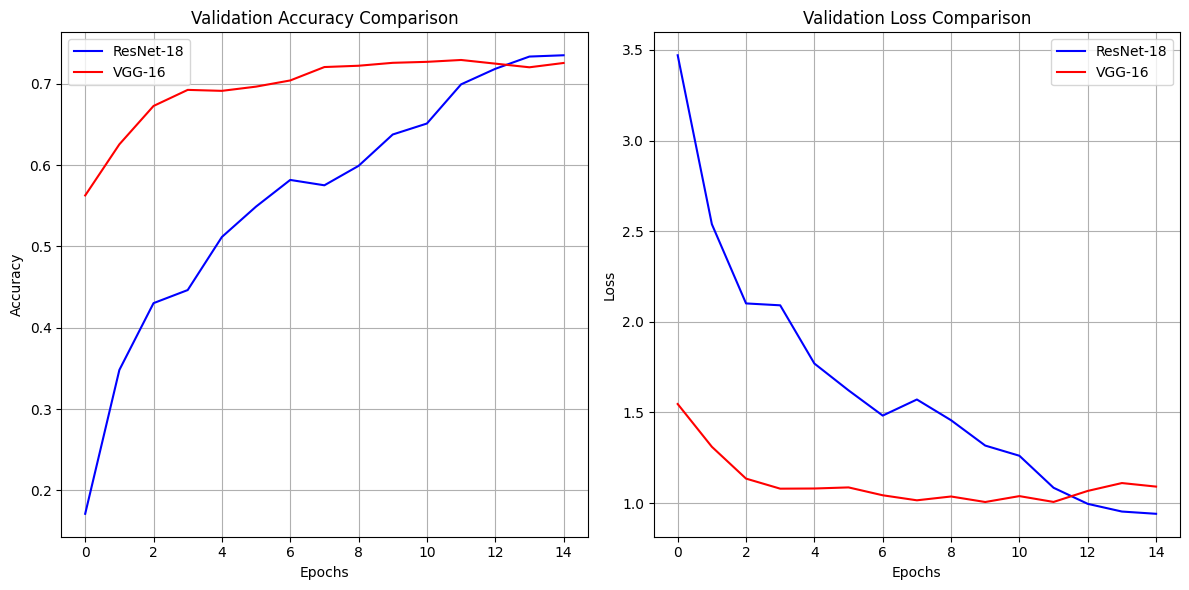

In [ ]:
# %%
def plot_comparison(resnet_history, vgg_history):
    plt.figure(figsize=(12, 6))

    # Accuracy comparison
    plt.subplot(1, 2, 1)
    plt.plot(resnet_history['test_acc'], label='ResNet-18', color='blue')
    plt.plot(vgg_history['test_acc'], label='VGG-16', color='red')
    plt.title('Validation Accuracy Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Loss comparison
    plt.subplot(1, 2, 2)
    plt.plot(resnet_history['test_loss'], label='ResNet-18', color='blue')
    plt.plot(vgg_history['test_loss'], label='VGG-16', color='red')
    plt.title('Validation Loss Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_comparison(resnet_history, vgg_history)

### 8. PCA Analysis of Learned Features
We can analyse how well the model is capable of separating features by using dimensionality reduction techniques on the penultimate layer befor the final classification. PCA is one of them.

Extracting features:   0%|          | 0/79 [00:00<?, ?it/s]

Extracting features:   0%|          | 0/79 [00:00<?, ?it/s]

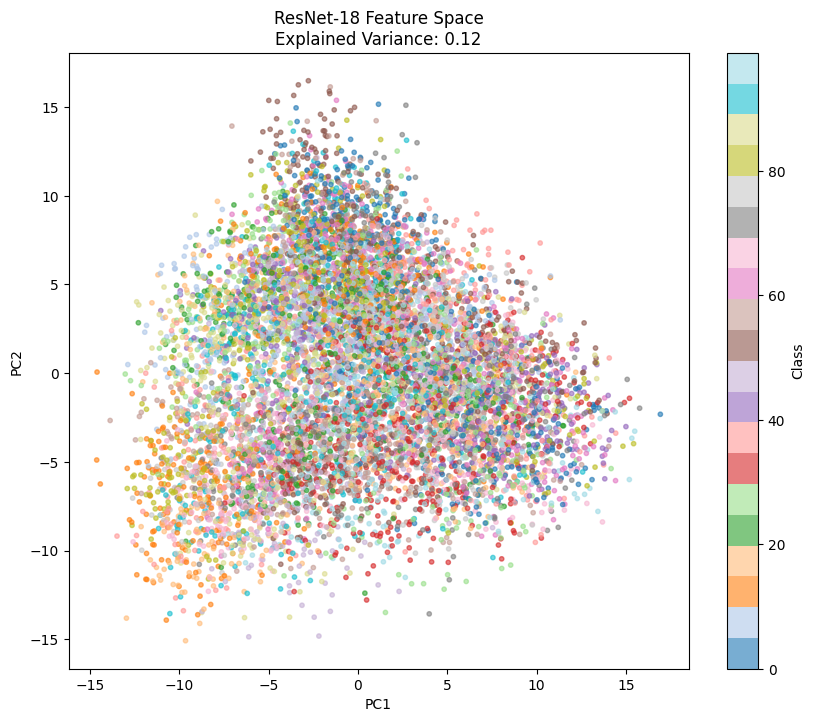

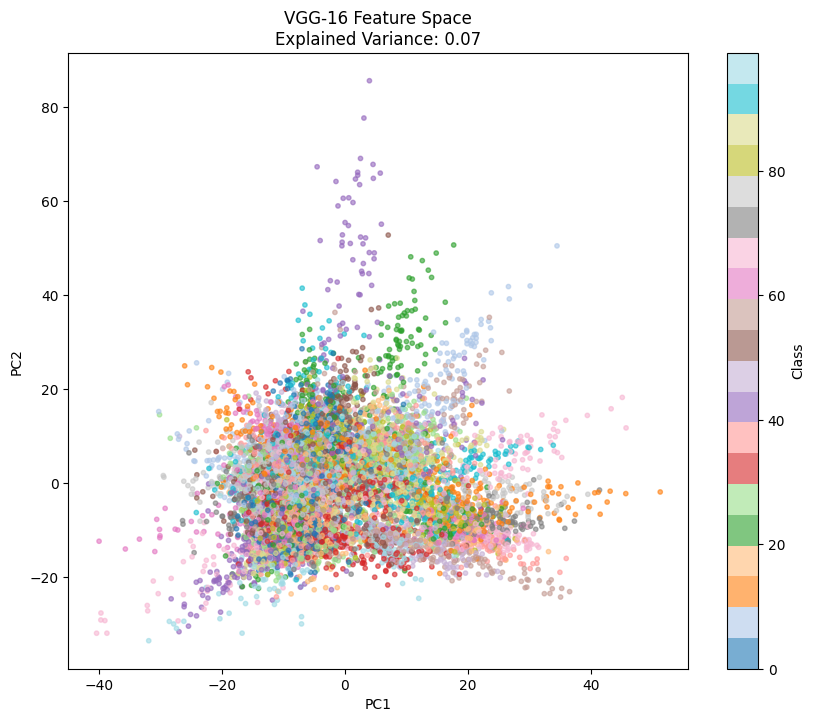

In [ ]:
def extract_features(model, dataloader, device):
    features = []
    labels_list = []
    handle = None

    # Register hook for ResNet
    if isinstance(model, models.ResNet):
        handle = model.fc.register_forward_hook(
            lambda module, input, output: features.append(input[0].detach().cpu().numpy()))
    # Register hook for VGG
    elif isinstance(model, models.VGG):
        handle = model.classifier[6].register_forward_hook(
            lambda module, input, output: features.append(input[0].detach().cpu().numpy()))

    model.eval()
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc='Extracting features'):
            inputs = inputs.to(device)
            _ = model(inputs)
            labels_list.append(labels.numpy())

    handle.remove()
    return np.concatenate(features), np.concatenate(labels_list)

def plot_pca(features, labels, title):
    # Standardize and PCA
    features = StandardScaler().fit_transform(features)
    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(features)

    plt.figure(figsize=(10, 8))
    plt.scatter(principal_components[:, 0], principal_components[:, 1],
                c=labels, cmap='tab20', alpha=0.6, s=10)
    plt.title(f'{title}\nExplained Variance: {pca.explained_variance_ratio_.sum():.2f}')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.colorbar(label='Class')
    plt.show()

# Extract features
resnet_features, resnet_labels = extract_features(resnet18, test_loader, device)
vgg_features, vgg_labels = extract_features(vgg16, test_loader, device)

# Plot PCA
plot_pca(resnet_features, resnet_labels, 'ResNet-18 Feature Space')
plot_pca(vgg_features, vgg_labels, 'VGG-16 Feature Space')

Note that the explained variance is quite low due to the limitations of PCA in a multidimensional environment as a linear method.

It is also possible to use tSNE for the same purpose:

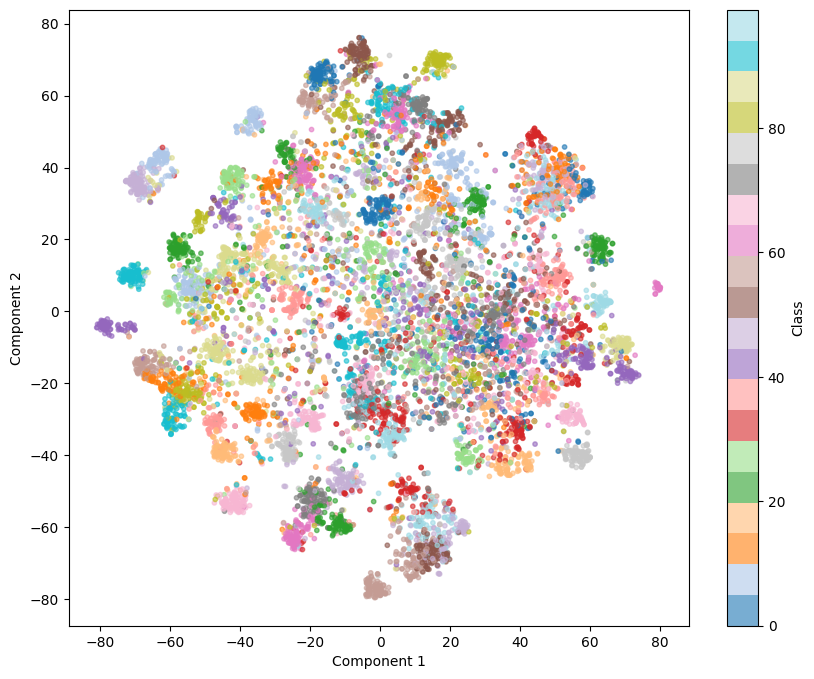

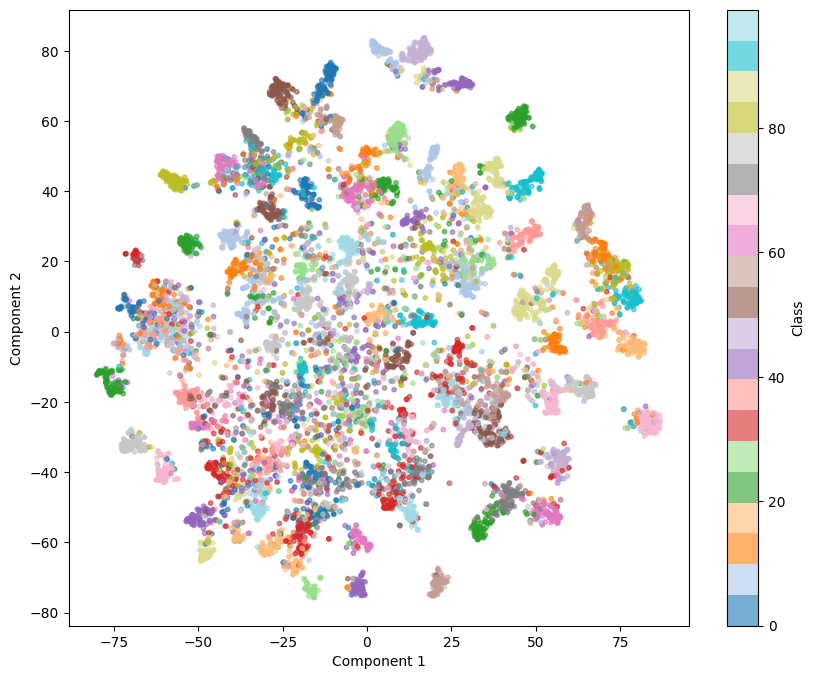

In [ ]:
def plot_tSNE(features, labels, title):
    # Standardize and tSNE
    features = StandardScaler().fit_transform(features)
    tsne = TSNE(n_components=2)
    components = tsne.fit_transform(features)

    plt.figure(figsize=(10, 8))
    plt.scatter(components[:, 0], components[:, 1],
                c=labels, cmap='tab20', alpha=0.6, s=10)
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.colorbar(label='Class')
    plt.show()

# Plot tSNE
plot_tSNE(resnet_features, resnet_labels, 'ResNet-18 Feature Space')
plot_tSNE(vgg_features, vgg_labels, 'VGG-16 Feature Space')

### 9. Feature Map Dimension Analysis

In [ ]:
def analyze_dimensions(model, model_name):
    dummy_input = torch.randn(1, 3, 32, 32).to(device)
    print(f"\n{model_name} Feature Map Dimensions:")

    if isinstance(model, models.ResNet):
        x = model.conv1(dummy_input)
        print(f"After conv1: {x.shape}")
        x = model.bn1(x)
        x = model.relu(x)
        print(f"After bn1+relu: {x.shape}")
        x = model.layer1(x)
        print(f"After layer1: {x.shape}")
        x = model.layer2(x)
        print(f"After layer2: {x.shape}")
        x = model.layer3(x)
        print(f"After layer3: {x.shape}")
        x = model.layer4(x)
        print(f"After layer4: {x.shape}")

    elif isinstance(model, models.VGG):
        for idx, layer in enumerate(model.features):
            dummy_input = layer(dummy_input)
            if isinstance(layer, nn.MaxPool2d):
                print(f"After pool{idx//4}: {dummy_input.shape}")

analyze_dimensions(resnet18, "ResNet-18")
analyze_dimensions(vgg16, "VGG-16")


ResNet-18 Feature Map Dimensions:
After conv1: torch.Size([1, 64, 32, 32])
After bn1+relu: torch.Size([1, 64, 32, 32])
After layer1: torch.Size([1, 64, 32, 32])
After layer2: torch.Size([1, 128, 16, 16])
After layer3: torch.Size([1, 256, 8, 8])
After layer4: torch.Size([1, 512, 4, 4])

VGG-16 Feature Map Dimensions:
After pool1: torch.Size([1, 64, 16, 16])
After pool2: torch.Size([1, 128, 8, 8])
After pool4: torch.Size([1, 256, 4, 4])
After pool5: torch.Size([1, 512, 2, 2])
After pool7: torch.Size([1, 512, 1, 1])


### 10. Gradient Flow Analysis


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


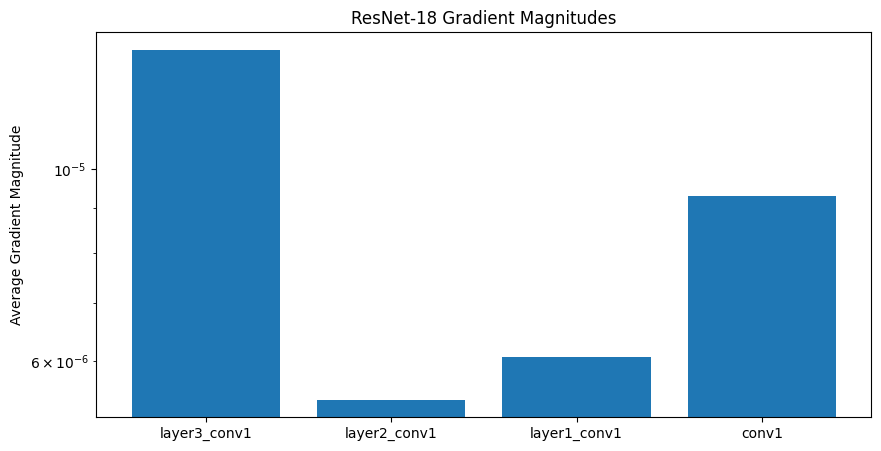

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


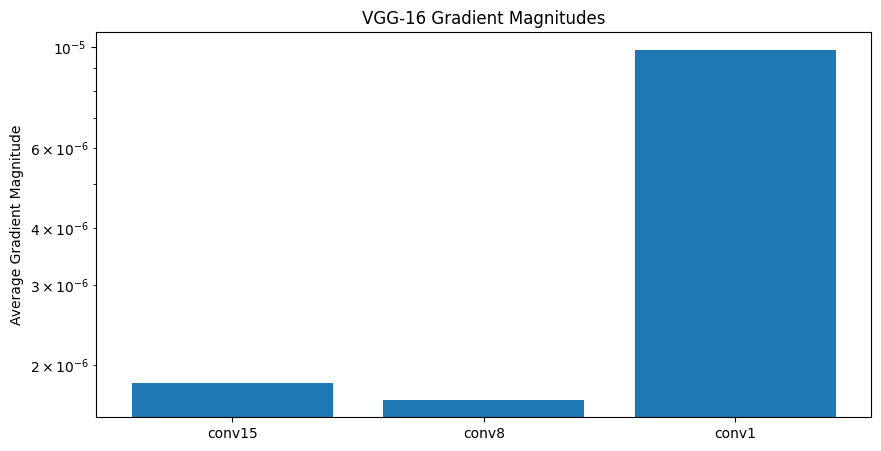

In [ ]:
def analyze_gradients(model, model_name):
    # Get sample batch
    inputs, labels = next(iter(test_loader))
    inputs, labels = inputs.to(device), labels.to(device)

    # Register hooks
    gradients = {}
    def save_grad(name):
        def hook(module, grad_input, grad_output):
            gradients[name] = grad_output[0].abs().mean().item()
        return hook

    if isinstance(model, models.ResNet):
        hooks = [
            model.conv1.register_backward_hook(save_grad('conv1')),
            model.layer1[0].conv1.register_backward_hook(save_grad('layer1_conv1')),
            model.layer2[0].conv1.register_backward_hook(save_grad('layer2_conv1')),
            model.layer3[0].conv1.register_backward_hook(save_grad('layer3_conv1')),
        ]
    elif isinstance(model, models.VGG):
        hooks = [
            model.features[0].register_backward_hook(save_grad('conv1')),
            model.features[7].register_backward_hook(save_grad('conv8')),
            model.features[14].register_backward_hook(save_grad('conv15')),
        ]

    # Forward + backward
    model.zero_grad()
    outputs = model(inputs)
    loss = CRITERION(outputs, labels)
    loss.backward()

    # Remove hooks
    for h in hooks:
        h.remove()

    # Plot
    plt.figure(figsize=(10, 5))
    plt.bar(range(len(gradients)), list(gradients.values()), tick_label=list(gradients.keys()))
    plt.title(f'{model_name} Gradient Magnitudes')
    plt.ylabel('Average Gradient Magnitude')
    plt.yscale('log')
    plt.show()

analyze_gradients(resnet18, "ResNet-18")
analyze_gradients(vgg16, "VGG-16")


### 11. Final Performance Summary


Final Results:
Model           | Best Val Acc | Final Val Acc
----------------------------------------
ResNet-18       | 0.7400       | 0.7400
VGG-16          | 0.6541       | 0.6461


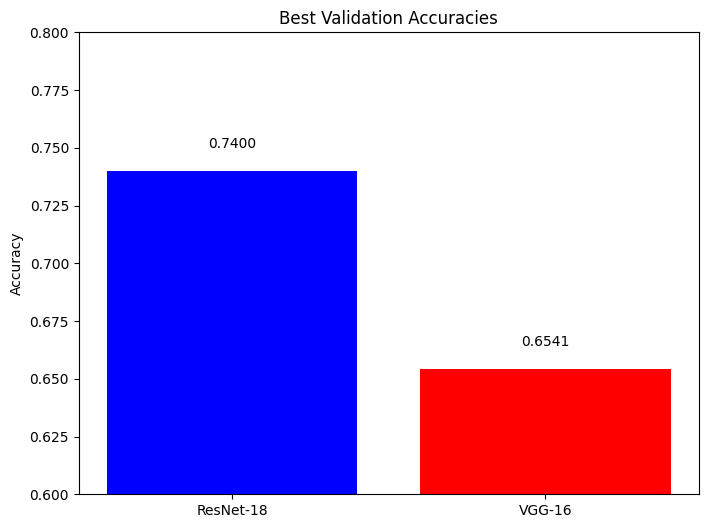

In [ ]:
def print_final_results(resnet_history, vgg_history):
    print("\nFinal Results:")
    print(f"{'Model':<15} | {'Best Val Acc':<12} | {'Final Val Acc':<12}")
    print("-" * 40)
    print(f"{'ResNet-18':<15} | {max(resnet_history['test_acc']):.4f}       | {resnet_history['test_acc'][-1]:.4f}")
    print(f"{'VGG-16':<15} | {max(vgg_history['test_acc']):.4f}       | {vgg_history['test_acc'][-1]:.4f}")

    plt.figure(figsize=(8, 6))
    models = ['ResNet-18', 'VGG-16']
    accuracies = [max(resnet_history['test_acc']), max(vgg_history['test_acc'])]
    plt.bar(models, accuracies, color=['blue', 'red'])
    plt.title('Best Validation Accuracies')
    plt.ylabel('Accuracy')х
    plt.ylim(0.6, 0.8)
    for i, v in enumerate(accuracies):
        plt.text(i, v + 0.01, f"{v:.4f}", ha='center')
    plt.show()

print_final_results(resnet_history, vgg_history)